In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from skimage import io, filters, morphology
from skimage.draw import polygon 
from scipy.ndimage import minimum_filter, gaussian_filter1d  # Added gaussian_filter1d import

from scipy.ndimage import generic_filter


In [3]:
image_path = 'C:/Users/ica/OneDrive - Plymouth Marine Laboratory/vscode/whitecaps/Stbd_2011_07_03_10_00_00.jpg'

In [4]:
im = io.imread(image_path).astype(np.float64)
#convert pixels into numbes


In [5]:
im=im/255
im_rg = (im[:,:,0] + im[:,:,1]) / 2
im_rg.min(), im_rg.max()
#turn into grayscale (0 to 1) 


(0.1803921568627451, 0.9274509803921569)

In [6]:
   
def moving_min(block):
    '''
    np.nanmin(block): Finds the minimum value in the block, ignoring NaN values
    np.ones_like(block): Creates an array of the same shape as the input, filled with ones
    Multiplies the minimum value by an array of ones, effectively creating a block where every pixel is set to the minimum value
    '''
    return np.nanmin(block) * np.ones_like(block)

In [7]:
#applies funciton with a 50x50 block for the whole image
background = ndi.minimum_filter(im_rg, size=(50, 50)) 


In [8]:
#background_smoothed = filters.gaussian(background, sigma=10) #singma is amount of smoothing

# Subtract background
im_subtracted = im_rg - background

In [9]:
im_subtracted.min()

0.0

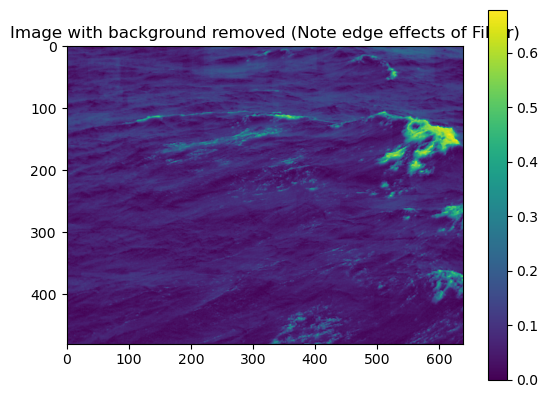

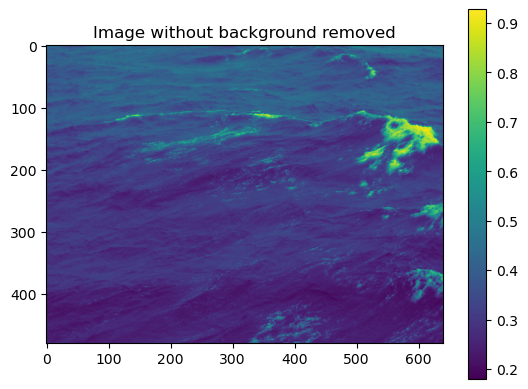

In [10]:
plt.figure(1)
plt.clf()
plt.title('Image with background removed (Note edge effects of Filter)')
plt.imshow(im_subtracted)
plt.colorbar()

plt.figure(2)
plt.clf()
plt.title('Image without background removed')
plt.imshow(im_rg)
plt.colorbar()

In [11]:
intensity_vector = np.arange(0, np.nanmax(im_subtracted)*0.9, 0.01)
'''
np.nanmax(im_subtracted): Finds the maximum intensity value in the image, ignoring NaN values.
*0.9: Multiplies by 0.9 to avoid extreme outliers at the maximum intensity.
np.arange(start, stop, step): Creates a range of intensity thresholds from 0 to 90% of the max intensity with a step size of 0.01. 
'''

# Calculate the PIP
hist, bin_edges = np.histogram(im_subtracted[~np.isnan(im_subtracted)], 
                                bins=intensity_vector)

'''
Counts how many pixel intensities fall within each range (bin) defined by the intensty vector
    Excludes NaN values to ensure valid calculations.
np.histogram: Computes the histogram, returning:
hist: Counts of pixels in each bin.
bin_edges: The boundaries of the bins.
'''

# Flip to start at highest intensity threshold to lowest
hist_reversed = hist[::-1]
bin_edges_reversed = bin_edges[::-1]

# Get cumulative sum at each successively lower intensity
cumulative_sum = np.cumsum(hist_reversed)

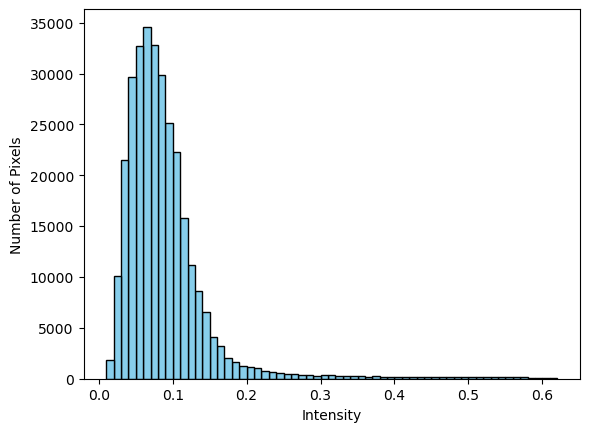

In [13]:
plt.bar(bin_edges_reversed[:-1], hist_reversed, width=np.diff(bin_edges), edgecolor='black', align='edge', color='skyblue')
plt.xlabel('Intensity')
plt.ylabel('Number of Pixels')
plt.show()

In [14]:
pip = np.gradient(cumulative_sum) / cumulative_sum


In [15]:
pip.max()

0.7395833333333334

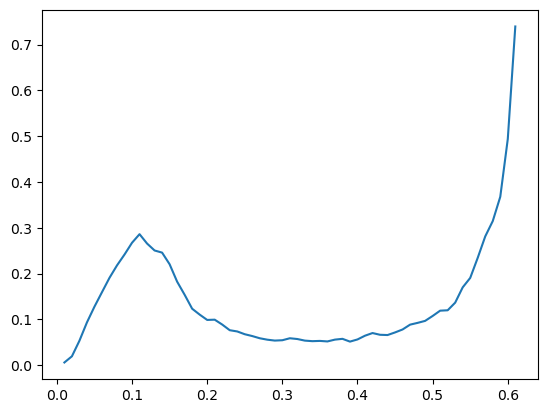

In [ ]:

plt.plot(bin_edges_reversed[:-1], pip)
plt.xlabel('Intensity')
plt.ylabel('PIP')



In [18]:
pip_smoothed =filters.gaussian(pip, sigma=5)


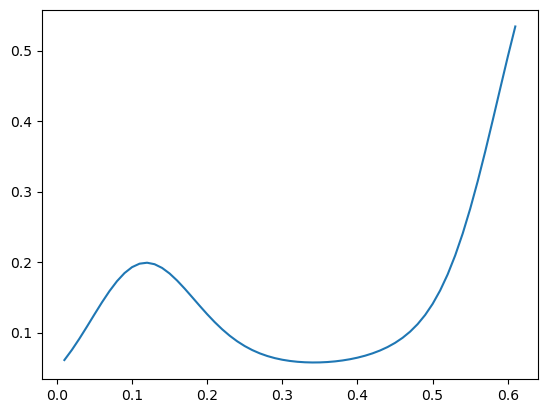

In [19]:
plt.plot(bin_edges_reversed[:-1], pip_smoothed)

In [26]:
pip_1 = np.gradient(pip_smoothed[::-1])
pip_2 = filters.gaussian(np.gradient(pip_1), sigma=5)
pip_3 = filters.gaussian(np.gradient(pip_2), sigma=5)


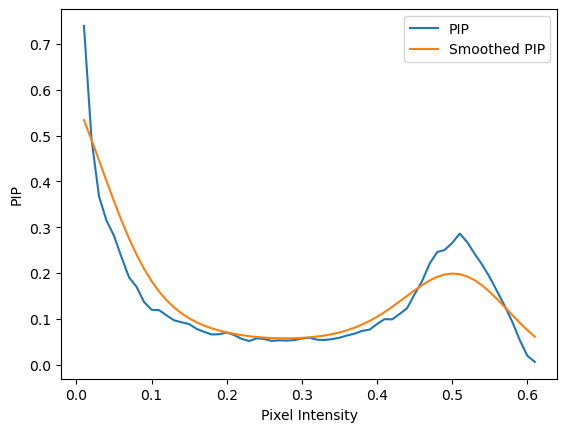

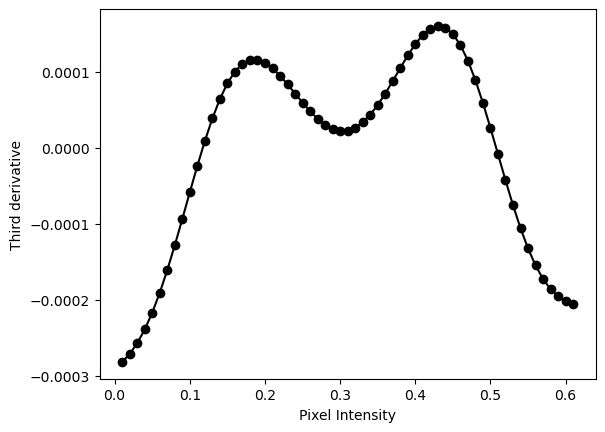

In [27]:
plt.figure(3)
plt.clf()
plt.plot(bin_edges[1:], pip,  label='PIP')
plt.plot(bin_edges[1:], pip_smoothed, label='Smoothed PIP')
plt.xlabel('Pixel Intensity')
plt.ylabel('PIP')
plt.legend()

plt.figure(4)
plt.plot(bin_edges[1:], pip_3[::-1], '-ko')
plt.xlabel('Pixel Intensity')
plt.ylabel('Third derivative')
plt.show()

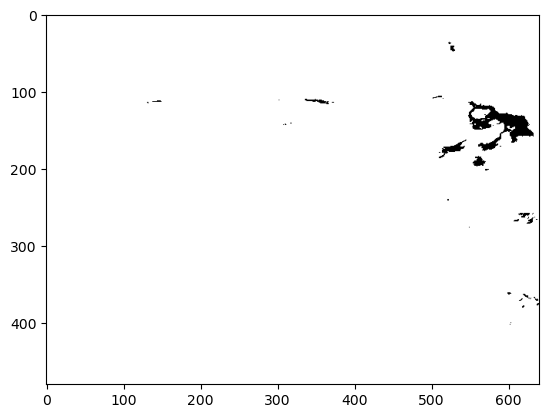

In [28]:
whitecap_mask = im_subtracted >0.44
plt.figure(5)
plt.imshow(whitecap_mask, cmap='binary')